In [17]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Add the parent directory to the system path
sys.path.append(os.path.abspath(".."))

# Import the module from the custom library
from _lib import utils
from _lib import layers
from _lib import metrics
from _lib import callbacks
from _lib import optimizers
from _lib import activations
from _lib import loss_functions
from _lib import FeedForward

### Constants and Hyperparameters

In [18]:
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split = 0.2 # Percentage of samples to use for validation
learning_rate = 1e-4 # Learning rate for the optimizer
batch_size = 16 # Number of samples to use for each batch
epochs = 300 # Number of epochs to train the model
seed = 1234 # Seed for reproducibility

In [19]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [20]:
# Load the digits dataset
digits = load_digits()

# Extract the number of classes in the dataset
num_classes = len(np.unique(digits.target)) # type: ignore

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=train_test_split_pct, random_state=seed) # type: ignore

# Split the training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=train_valid_split, random_state=seed) # type: ignore

# Print the dataset information
print("Number of classes:", num_classes)
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:', X_valid.shape, y_valid.shape)
print('Testing set:', X_test.shape, y_test.shape)

Number of classes: 10
Training set: (1149, 64) (1149,)
Validation set: (288, 64) (288,)
Testing set: (360, 64) (360,)


### Data Preprocessing

In [21]:
# Normalization
def normalize(X: np.ndarray) -> np.ndarray:
    """
    Normalize the input data by dividing by the maximum value in the training set.
    
    Parameters:
    - X (np.ndarray): The input data to normalize
    
    Returns:
    - np.ndarray: The normalized input data
    """
    
    # Normalize the input data
    return X / 255.0

# Normalize the input data
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

In [22]:
# Convert the target values to one-hot encoded vectors
y_train_encoded = utils.one_hot_encoding(y=y_train, n_classes=num_classes)
y_valid_encoded = utils.one_hot_encoding(y=y_valid, n_classes=num_classes)

# Print one sample encoding
print("Sample target value:", y_train[0])
print("One-hot encoded value:", y_train_encoded[0])

Sample target value: 1
One-hot encoded value: [0 1 0 0 0 0 0 0 0 0]


### Data visualization

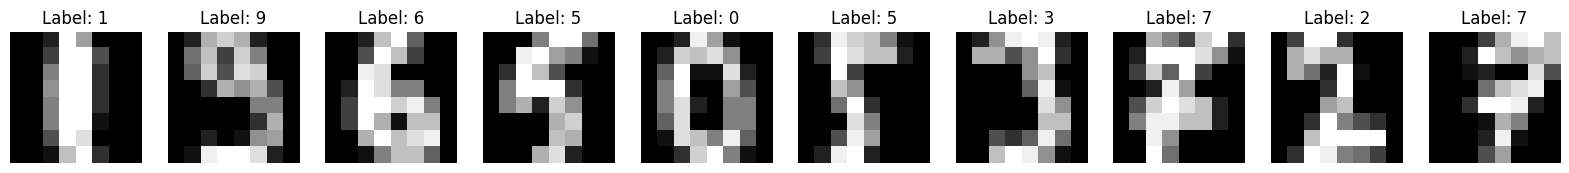

In [23]:
def plot_samples(samples: list[np.ndarray], labels: list[np.ndarray]) -> None:
    """
    Plot the samples in a grid.
    
    Parameters:
    - samples (list[np.ndarray]): The samples to plot
    - labels (list[np.ndarray]): The labels of the samples
    """
    
    reshaped_samples = []
    # Iterate over the samples
    for sample in samples:
        # Compute the new shape
        new_shape = np.sqrt(sample.shape).astype(int)[0]
        
        # Reshape the sample
        sample = sample.reshape(new_shape, new_shape)
        
        # Append the reshaped sample
        reshaped_samples.append(sample)
        
    # Plot the samples in a grid
    fig, axes = plt.subplots(1, len(samples), figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(reshaped_samples[i], cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
        
        
# Plot the first 10 samples
plot_samples(list(X_train[:10]), y_train[:10])

### Building the model

In [24]:

model = FeedForward([
    layers.Dense(num_units=24, activation=activations.ReLU()),
    layers.BatchNormalization(momentum=0.9),
    layers.Dropout(rate=0.1),
    layers.Dense(num_units=32, activation=activations.ReLU()),
    layers.Dropout(rate=0.1),
    layers.Dense(num_units=12, activation=activations.Tanh()),
    layers.Dropout(rate=0.1),
    layers.Dense(num_units=num_classes, activation=activations.Softmax())
])

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Initialize the loss function
loss_fn = loss_functions.CrossEntropy()

In [25]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size
model(X_train[:batch_size]);

In [26]:
# Display the model summary
model.summary()


Neural Network (ID: 1)

--------------------------------------------------------------------------------
Layer (type)                            Output Shape        Trainable params #  
dense_1 (Dense)                         (16, 24)            1560                
--------------------------------------------------------------------------------
batch_normalization_2                   
(BatchNormalization)                    (16, 24)            48                  
--------------------------------------------------------------------------------
dropout_3 (Dropout)                     (16, 24)            0                   
--------------------------------------------------------------------------------
dense_4 (Dense)                         (16, 32)            800                 
--------------------------------------------------------------------------------
dropout_5 (Dropout)                     (16, 32)            0                   
-------------------------------------------

### Training the model

In [27]:
history = model.fit(
    X_train = X_train, 
    y_train = y_train_encoded,
    optimizer = optimizer,
    loss_fn = loss_fn,
    X_valid = X_valid,
    y_valid = y_valid_encoded,
    batch_size = batch_size,
    epochs = epochs,
    metrics = [metrics.accuracy],
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

Epoch 1/300 --> loss: 2.2874 - accuracy: 0.2463 | Validation loss: 2.2890 - Validation accuracy: 0.2743
Epoch 2/300 --> loss: 2.2521 - accuracy: 0.3534 | Validation loss: 2.2211 - Validation accuracy: 0.3924
Epoch 3/300 --> loss: 2.2135 - accuracy: 0.4378 | Validation loss: 2.1809 - Validation accuracy: 0.4514
Epoch 4/300 --> loss: 2.1715 - accuracy: 0.4952 | Validation loss: 2.1301 - Validation accuracy: 0.5000
Epoch 5/300 --> loss: 2.1269 - accuracy: 0.5283 | Validation loss: 2.0768 - Validation accuracy: 0.5208
Epoch 6/300 --> loss: 2.0784 - accuracy: 0.5509 | Validation loss: 2.0126 - Validation accuracy: 0.5486
Epoch 7/300 --> loss: 2.0204 - accuracy: 0.5527 | Validation loss: 1.9443 - Validation accuracy: 0.5312
Epoch 8/300 --> loss: 1.9655 - accuracy: 0.5875 | Validation loss: 1.8802 - Validation accuracy: 0.5590
Epoch 9/300 --> loss: 1.9011 - accuracy: 0.5718 | Validation loss: 1.8128 - Validation accuracy: 0.5417
Epoch 10/300 --> loss: 1.8452 - accuracy: 0.5892 | Validation lo

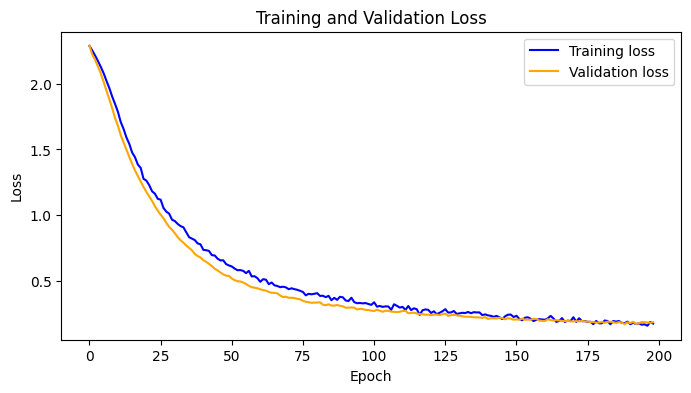

In [28]:
# Plot the training and validation loss
utils.plot_history(history["loss"], history["val_loss"], "Training and Validation Loss", "Epoch", "Loss")

### Model evaluation

In [29]:
# Predict the labels
predictions = model(X_test)

# Apply the argmax function to the predictions
predictions = np.argmax(predictions, axis=1)

Accuracy: 0.96


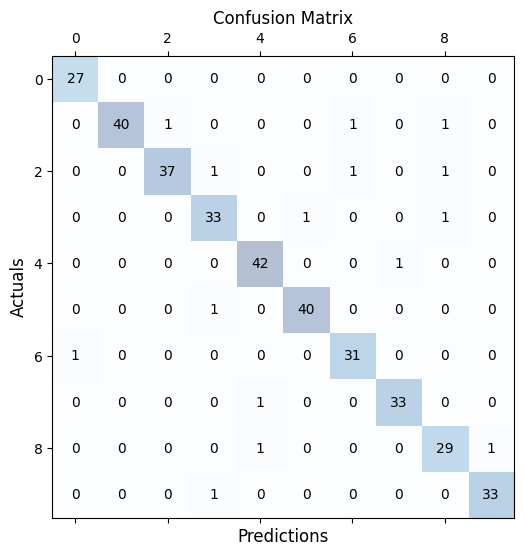

In [30]:
# Compute the accuracy
accuracy = metrics.accuracy(predictions, y_test)
confusion_matrix = metrics.confusion_matrix(num_classes, predictions, y_test)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

# Plot the confusion matrix
utils.plot_confusion_matrix(confusion_matrix)